# Analysis of Single Cell
- Ruoyi Jiang
- July 6, 2024
1. any difference in counts of relevant cell subsets e.g. pcDC, T cell, B cell (normalize as well) X
2. any difference in GEX of keratinocyte, fibroblast, endothelial, T cell X
3. integrate with spatial to validate cell count differences and see where cell count differences are occuring

In [1]:
library(Seurat)
library(ggplot2)
library(tidyverse)
library(RColorBrewer)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


── Attaching core tidyverse packages ─────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ───────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
#Plotting
plotFigure <- function(plot, file, width, height){
    pdf(file, width=width, height=height)
    plot(plot)
    dev.off()
}

In [3]:
plotGene <- function(object, gene_name, plot_cell = NULL, type = "pca"){
    
    if(is.null(plot_cell)){
        plot_cell <- rep(TRUE, length(object@active.ident))
    }
    
    expr_vec <- object@assays$SCT@data[gene_name, plot_cell]
    identity_df <- data.frame(IDENTITY = object@active.ident[plot_cell])
    
    if(type == "pca"){
        projection_df <- data.frame(object@reductions$pca@cell.embeddings)
        p <- ggplot(projection_df[plot_cell,], aes(x = PC1, y = PC2))
    }
    if(type == "umap"){
        projection_df <- data.frame(object@reductions$umap@cell.embeddings)[plot_cell,]
        p <- ggplot(projection_df, aes(x = umap_1, y = umap_2))
    }
        
    p <- p + 
        theme_bw() +
        theme( axis.title.x=element_text(size=12), axis.title.y=element_text(size=12),
                 axis.text.x=element_blank(),
                axis.ticks.x=element_blank(),
              axis.text.y=element_blank(),
                axis.ticks.y=element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank()
             ) +
        scale_colour_gradient2(low = "#EBEBEB", mid = "#D9D9D9",
          high = "#132B43", name=gene_name) +
        geom_point(size = 0.2, aes(color=as.numeric(expr_vec)), alpha = 0.8) +
        xlab("Component 1") +
        ylab("Component 2")
    
    return(p)
}

In [4]:
plot_dir <- "/home/ruoyi/Dropbox/Projects/Gelhausen_CLE/figures"

In [5]:
output_dir <- "/home/ruoyi/Dropbox/Projects/Gelhausen_CLE/Spatial/data"

In [6]:
meta_df <- read.csv("/home/ruoyi/Dropbox/Projects/Gelhausen_CLE/meta.csv") %>%
    filter(METHOD == "SINGLECELL")

In [7]:
meta_df

SAMPLE,PATIENT,STATUS,DISEASE,TREATMENT,PATH,METHOD
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
CLE1,P1,LUPUS,LE,BEFORE,/home/ruoyi/andromeda/projects/gelhausen_cle/single_cell/CLE1_filtered_feature_bc_matrix.h5,SINGLECELL
CLE2,P2,LUPUS,LE,BEFORE,/home/ruoyi/andromeda/projects/gelhausen_cle/single_cell/CLE2_filtered_feature_bc_matrix.h5,SINGLECELL
CLE3,P3,LUPUS,LE,BEFORE,/home/ruoyi/andromeda/projects/gelhausen_cle/single_cell/CLE3_filtered_feature_bc_matrix.h5,SINGLECELL
CLE5,P5,LUPUS,LE,BEFORE,/home/ruoyi/andromeda/projects/gelhausen_cle/single_cell/CLE5_filtered_feature_bc_matrix.h5,SINGLECELL
CTRL1,P1,HEALTHY,HEALTHY,BEFORE,/home/ruoyi/andromeda/projects/gelhausen_cle/single_cell/CTRL1_filtered_feature_bc_matrix.h5,SINGLECELL
CTRL2,P2,HEALTHY,HEALTHY,BEFORE,/home/ruoyi/andromeda/projects/gelhausen_cle/single_cell/CTRL2_filtered_feature_bc_matrix.h5,SINGLECELL
CTRL3,P3,HEALTHY,HEALTHY,BEFORE,/home/ruoyi/andromeda/projects/gelhausen_cle/single_cell/CTRL3_filtered_feature_bc_matrix.h5,SINGLECELL
CTRL4,P4,HEALTHY,HEALTHY,BEFORE,/home/ruoyi/andromeda/projects/gelhausen_cle/single_cell/CTRL4_filtered_feature_bc_matrix.h5,SINGLECELL
CTRL5,P5,HEALTHY,HEALTHY,BEFORE,/home/ruoyi/andromeda/projects/gelhausen_cle/single_cell/CTRL5_filtered_feature_bc_matrix.h5,SINGLECELL


In [8]:
DISEASE_NAMES <- list(
'HEALTHY' = 'Uninvolved',
'LUPUS' = 'DLE'
)

DISEASE_COLORS <- c(
'Uninvolved' = '#79C5F0',
'DLE' = '#CC6666'
)

DISEASE_ORDER <- c('Uninvolved', 'DLE')

# Load data into Seurat and Normalize

In [5]:
meta_list <- meta_df %>%
    split(.$SAMPLE) %>%
    map(~select(., -SAMPLE))

In [6]:
obj_list <- list()
for(sample in names(meta_list)){
    obj_list[[sample]] <- Read10X_h5(unlist(meta_list[[sample]])['PATH']) %>% CreateSeuratObject()
    obj_list[[sample]]@meta.data$SAMPLE <- sample
    obj_list[[sample]]@meta.data <- bind_cols(obj_list[[sample]]@meta.data, meta_list[[sample]] %>% select(-PATH, -METHOD))
}

In [7]:
obj_list <- lapply(X = obj_list, FUN = function(x) {
    #x <- subset(x, downsample=3000)
    x <- NormalizeData(x) %>% FindVariableFeatures(selection.method = "vst", nfeatures = 3000)
    x <- SCTransform(x, verbose = FALSE) %>% RunPCA(verbose = FALSE)
})

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts



In [8]:
features <- SelectIntegrationFeatures(object.list = obj_list)

In [9]:
prep <- PrepSCTIntegration(object.list = obj_list, anchor.features = features)

In [10]:
immune.anchors <- FindIntegrationAnchors(object.list = prep, anchor.features = features, normalization.method = "SCT", reduction = "rpca",
    k.anchor = 15)
immune.combined <- IntegrateData(anchorset = immune.anchors, normalization.method = "SCT")
DefaultAssay(immune.combined) <- "integrated"

Warning message in CheckDuplicateCellNames(object.list = object.list):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Computing within dataset neighborhoods

Finding all pairwise anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 5168 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 9096 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 8233 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 8863 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 6680 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 10477 anchors

Projecting new data onto SVD

Proje

[1] 1


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 2


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 3


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 4


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 5


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 6


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 7


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 8


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 9


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Merging dataset 6 into 9

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Merging dataset 5 into 7

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Merging dataset 9 6 into 7 5

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Merging dataset 1 into 3

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

W

In [26]:
immune.combined <- immune.combined %>%
	RunPCA(npcs = 22, verbose = FALSE) %>%
	RunUMAP(reduction = "pca", dims = 1:22) %>%
	FindNeighbors(reduction = "pca", dims = 1:22) 

15:02:59 UMAP embedding parameters a = 0.9922 b = 1.112

15:02:59 Read 34258 rows and found 22 numeric columns

15:02:59 Using Annoy for neighbor search, n_neighbors = 30

15:02:59 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:03:03 Writing NN index file to temp file /tmp/RtmpHa4uQD/file68c2d2452d071

15:03:03 Searching Annoy index using 1 thread, search_k = 3000

15:03:15 Annoy recall = 100%

15:03:16 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

15:03:18 Initializing from normalized Laplacian + noise (using RSpectra)

15:03:23 Commencing optimization for 200 epochs, with 1496044 positive edges

15:03:45 Optimization finished

Computing nearest neighbor graph

Computing SNN



In [30]:
immune.combined <- immune.combined %>%
	FindClusters(resolution = 0.25)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 34258
Number of edges: 1304959

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9706
Number of communities: 20
Elapsed time: 7 seconds


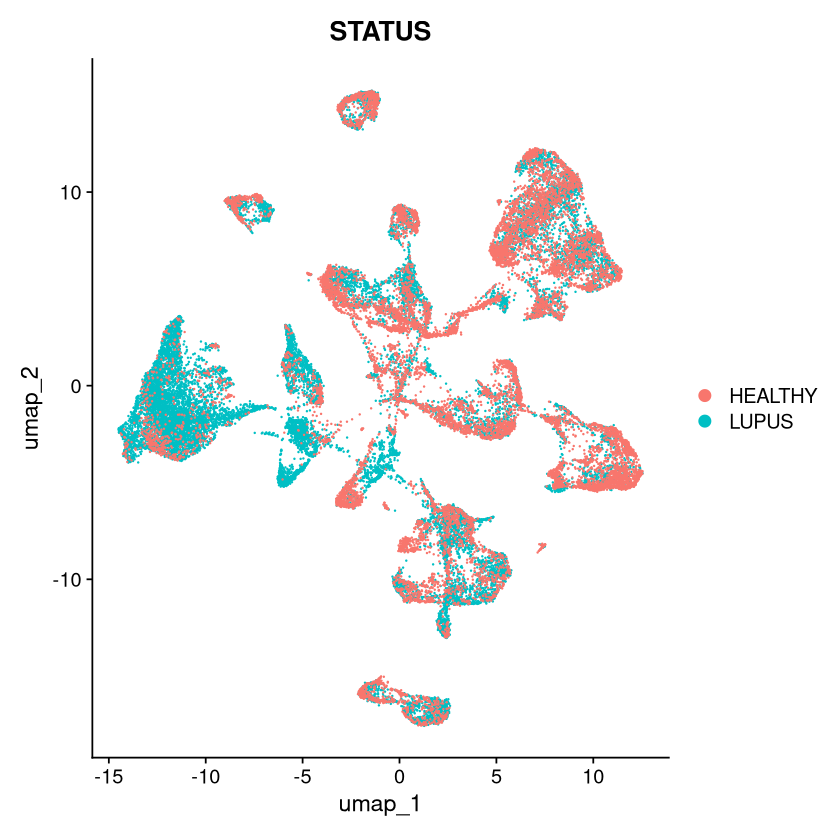

In [31]:
# Visualization
DimPlot(immune.combined , reduction = "umap", group.by = "STATUS")

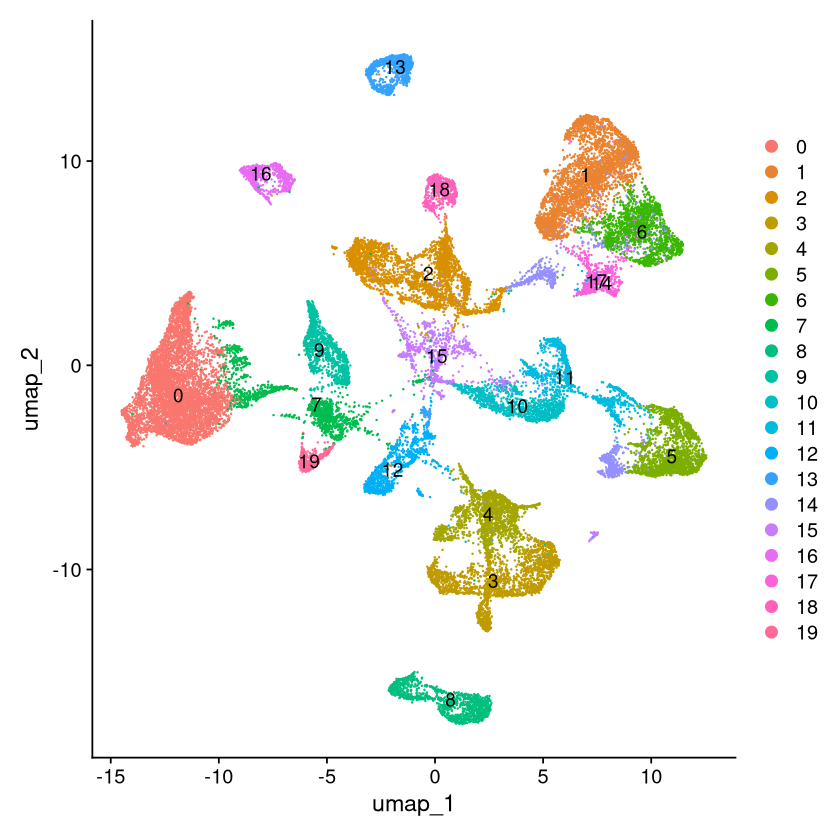

In [32]:
# Visualization
DimPlot(immune.combined, reduction = "umap", label = TRUE)

# Load Seurat Object

In [9]:
immune.combined <- readRDS(file.path(output_dir, "single.combined.rds"))

# Label seurat clusters

In [478]:
pseudo_immune_clusters <- AggregateExpression(immune.combined, assays = "SCT", 
                                   return.seurat = T, group.by = c("seurat_clusters"))

In [25]:
pseudo_immune_clusters@assays$SCT$data %>% data.frame() %>%
    rownames_to_column("GENE") %>%
    filter(GENE == "CD3E") %>% gather(CLUSTER, EXPR, -GENE) %>% filter(EXPR > 1.5)

GENE,CLUSTER,EXPR
<chr>,<chr>,<dbl>
CD3E,g0,2.07322


In [40]:
pseudo_immune_clusters@assays$SCT$data %>% data.frame() %>%
    rownames_to_column("GENE") %>%
    filter(GENE == "KRT5") %>% gather(CLUSTER, EXPR, -GENE) %>% filter(EXPR > 1.5)

GENE,CLUSTER,EXPR
<chr>,<chr>,<dbl>
KRT5,g2,3.650507
KRT5,g15,2.599371
KRT5,g18,2.608385


In [58]:
pseudo_immune_clusters@assays$SCT$data %>% data.frame() %>%
    rownames_to_column("GENE") %>%
    filter(GENE == "KRT7") %>% gather(CLUSTER, EXPR, -GENE) %>% filter(EXPR > 2.0)

GENE,CLUSTER,EXPR
<chr>,<chr>,<dbl>
KRT7,g5,3.052066
KRT7,g10,3.198961
KRT7,g11,3.276291


In [27]:
pseudo_immune_clusters@assays$SCT$data %>% data.frame() %>%
    rownames_to_column("GENE") %>%
    filter(GENE == "COL1A1") %>% gather(CLUSTER, EXPR, -GENE) %>% filter(EXPR > 2.0)

GENE,CLUSTER,EXPR
<chr>,<chr>,<dbl>
COL1A1,g3,3.637461
COL1A1,g4,4.493203


In [30]:
pseudo_immune_clusters@assays$SCT$data %>% data.frame() %>%
    rownames_to_column("GENE") %>%
    filter(GENE == "MS4A1") %>% gather(CLUSTER, EXPR, -GENE) %>% filter(EXPR > 1.5)

GENE,CLUSTER,EXPR
<chr>,<chr>,<dbl>
MS4A1,g7,1.878329


In [28]:
pseudo_immune_clusters@assays$SCT$data %>% data.frame() %>%
    rownames_to_column("GENE") %>%
    filter(GENE == "MYL9") %>% gather(CLUSTER, EXPR, -GENE) %>% filter(EXPR > 2.0)

GENE,CLUSTER,EXPR
<chr>,<chr>,<dbl>
MYL9,g8,3.703361


In [44]:
pseudo_immune_clusters@assays$SCT$data %>% data.frame() %>%
    rownames_to_column("GENE") %>%
    filter(GENE == "PECAM1") %>% gather(CLUSTER, EXPR, -GENE) %>% filter(EXPR > 2.5)

GENE,CLUSTER,EXPR
<chr>,<chr>,<dbl>
PECAM1,g1,2.929126
PECAM1,g6,2.829918
PECAM1,g17,2.827933


In [45]:
pseudo_immune_clusters@assays$SCT$data %>% data.frame() %>%
    rownames_to_column("GENE") %>%
    filter(GENE == "LYVE1") %>% gather(CLUSTER, EXPR, -GENE) %>% filter(EXPR > 2.0)

GENE,CLUSTER,EXPR
<chr>,<chr>,<dbl>
LYVE1,g13,2.404425


In [64]:
pseudo_immune_clusters@assays$SCT$data %>% data.frame() %>%
    rownames_to_column("GENE") %>%
    filter(GENE == "CD68") %>% gather(CLUSTER, EXPR, -GENE) %>% filter(EXPR > 2.0)

GENE,CLUSTER,EXPR
<chr>,<chr>,<dbl>
CD68,g9,2.186898


In [67]:
pseudo_immune_clusters@assays$SCT$data %>% data.frame() %>%
    rownames_to_column("GENE") %>%
    filter(GENE == "PMEL") %>% gather(CLUSTER, EXPR, -GENE) %>% filter(EXPR > 2.0)

GENE,CLUSTER,EXPR
<chr>,<chr>,<dbl>
PMEL,g12,3.771724


In [191]:
pseudo_immune_clusters@assays$SCT$data %>% data.frame() %>%
    rownames_to_column("GENE") %>%
    filter(GENE == "HBB") %>% gather(CLUSTER, EXPR, -GENE) %>% filter(EXPR > 8.0)

GENE,CLUSTER,EXPR
<chr>,<chr>,<dbl>
HBB,g16,8.60294


In [72]:
pseudo_immune_clusters@assays$SCT$data %>% data.frame() %>%
    rownames_to_column("GENE") %>%
    filter(GENE == "IL3RA") %>% gather(CLUSTER, EXPR, -GENE) %>% filter(EXPR > 1.5)

GENE,CLUSTER,EXPR
<chr>,<chr>,<dbl>
IL3RA,g19,1.909315


In [479]:
marker_df <- read.csv(file.path("/home/ruoyi/Dropbox/Projects/Gelhausen_CLE/Spatial", "singlecell_markers.csv"))

In [480]:
intermediate_assignment_df <- pseudo_immune_clusters@assays$SCT$data %>% data.frame() %>%
    rownames_to_column("GENE") %>% 
    gather(CLUSTER, EXPR, -GENE) %>% 
    left_join(marker_df) %>% na.omit() 

Joining with `by = join_by(GENE)`


In [481]:
# note g14 had no assignment, just debris
final_assignment_df <- intermediate_assignment_df %>% 
    filter(EXPR>THRESHOLD) %>% select(CLUSTER, ASSIGNMENT,GENE) %>% rename(FINAL_ASSIGNMENT = ASSIGNMENT)

In [482]:
final_assignment_df <- final_assignment_df %>% bind_rows(data.frame(CLUSTER = "g14", FINAL_ASSIGNMENT = "Debris"))

In [483]:
gene_order <- final_assignment_df %>% na.omit() %>% distinct(GENE) %>% select(GENE) %>% unlist() %>% as.character()
assignment_order <- final_assignment_df %>% distinct(FINAL_ASSIGNMENT) %>% select(FINAL_ASSIGNMENT) %>% unlist() %>% as.character()
cluster_order <- final_assignment_df %>% distinct(CLUSTER) %>% select(CLUSTER) %>% unlist() %>% rev() %>% as.character()

Joining with `by = join_by(CLUSTER)`


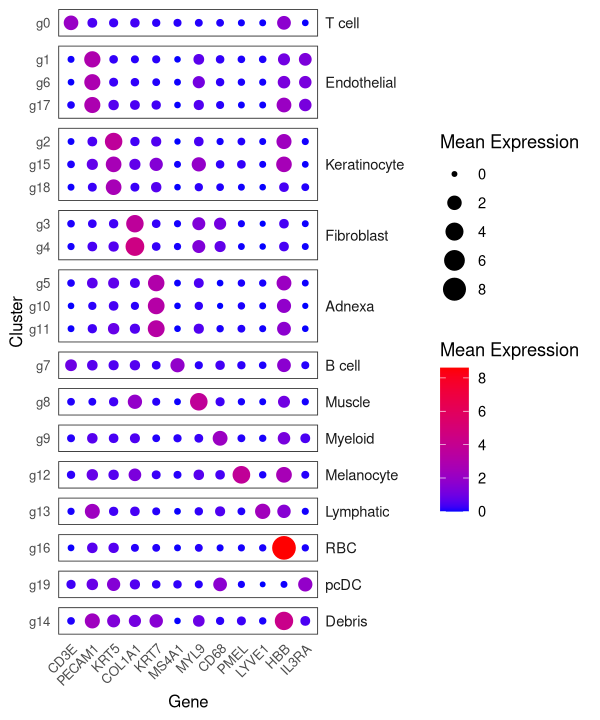

In [485]:
options(repr.plot.width = 5, repr.plot.height = 6)
p <- intermediate_assignment_df %>% left_join(final_assignment_df %>% select(CLUSTER, FINAL_ASSIGNMENT) %>% na.omit()) %>% 
    ungroup() %>% 
    mutate(
        FINAL_ASSIGNMENT = factor(FINAL_ASSIGNMENT, levels=assignment_order),
        CLUSTER = factor(CLUSTER, levels=cluster_order),
        GENE = factor(GENE, levels=gene_order)) %>%
                            
    ggplot(aes(y = CLUSTER, x = GENE)) +
      geom_point(aes(colour=EXPR, size=EXPR)) + 
    scale_size(name = "Mean Expression") +
      scale_color_gradient(low="blue", high="red", name = "Mean Expression") +
        xlab("Gene") +
        ylab("Cluster") +
        theme_bw() +
        theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank(), strip.background = element_blank(), 
              axis.title.x=element_text(size=10), axis.title.y=element_text(size=10),
                 axis.text.x=element_text(size=8, angle = 45, hjust=1, vjust=1),
                axis.ticks.x=element_blank(),
              axis.text.y=element_text(size=8),
                axis.ticks.y=element_blank(),
              strip.text.y = element_text(angle = 0, hjust=0)
             ) + facet_grid(rows=vars(FINAL_ASSIGNMENT), drop=F, scales="free_y", space="free_y") 
plot(p)

In [488]:
plotFigure(p, file.path(plot_dir, "single_cell_dotplot.pdf"), 5, 6)

png 
  2

In [491]:
CLUSTER_COLORS <- colorRampPalette(brewer.pal(12, "Paired"))(length(unique(final_assignment_df$CLUSTER)))
names(CLUSTER_COLORS) <- unique(final_assignment_df$CLUSTER)
FINAL_ASSIGNMENT_COLORS <- colorRampPalette(brewer.pal(12, "Paired"))(length(unique(final_assignment_df$FINAL_ASSIGNMENT)))
names(FINAL_ASSIGNMENT_COLORS) <- unique(final_assignment_df$FINAL_ASSIGNMENT)

In [492]:
object <- immune.combined

projection_df <- data.frame(object@reductions$umap@cell.embeddings) %>%
    mutate(IDENTITY = object@active.ident) %>% mutate(CLUSTER = paste0("g",IDENTITY)) %>% 
    left_join(final_assignment_df)

label_df <- projection_df %>%
    group_by(FINAL_ASSIGNMENT) %>%
    summarize(projection_1 = mean(umap_1), projection_2 = mean(umap_2)) %>% ungroup()

Joining with `by = join_by(CLUSTER)`


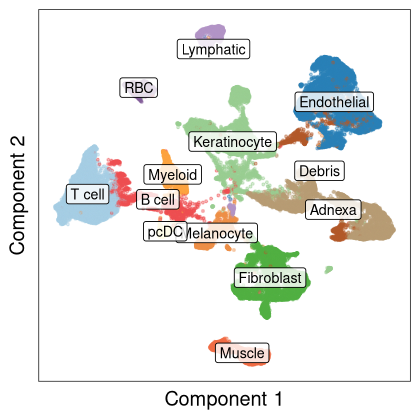

In [493]:
options(repr.plot.width = 3.5, repr.plot.height = 3.5)

p <- ggplot(projection_df, aes(x = umap_1, y = umap_2)) + 
theme_bw() +
theme(legend.position="none", legend.title=element_blank(), axis.title.x=element_text(size=12), axis.title.y=element_text(size=12),
         axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
      axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),panel.grid.major=element_blank(), panel.grid.minor=element_blank()
     ) +
scale_color_manual(values=FINAL_ASSIGNMENT_COLORS) +
geom_point(size = 0.5, aes(color=FINAL_ASSIGNMENT), alpha = 0.4) +
geom_label(data=label_df, aes(x=projection_1, y=projection_2, label = FINAL_ASSIGNMENT), size = 3, alpha = 0.8) +
xlab("Component 1") +
ylab("Component 2")
plot(p)

In [494]:
plotFigure(p, file.path(plot_dir, "single_umap_assignments.pdf"), 5, 5)

png 
  2

In [495]:
object <- immune.combined

projection_df <- data.frame(object@reductions$umap@cell.embeddings) %>%
    mutate(IDENTITY = object@active.ident) %>% mutate(CLUSTER = paste0("g",IDENTITY)) %>% 
    left_join(final_assignment_df)

label_df <- projection_df %>%
    group_by(IDENTITY) %>%
    summarize(projection_1 = mean(umap_1), projection_2 = mean(umap_2)) %>% ungroup()

Joining with `by = join_by(CLUSTER)`


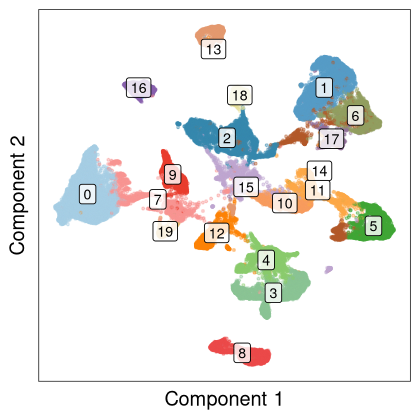

In [496]:
options(repr.plot.width = 3.5, repr.plot.height = 3.5)

p <- ggplot(projection_df, aes(x = umap_1, y = umap_2)) + 
theme_bw() +
theme(legend.position="none", legend.title=element_blank(), axis.title.x=element_text(size=12), axis.title.y=element_text(size=12),
         axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
      axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),panel.grid.major=element_blank(), panel.grid.minor=element_blank()
     ) +
scale_color_manual(values=CLUSTER_COLORS) +
geom_point(size = 0.5, aes(color=CLUSTER), alpha = 0.4) +
geom_label(data=label_df, aes(x=projection_1, y=projection_2, label = IDENTITY), size = 3, alpha = 0.8) +
xlab("Component 1") +
ylab("Component 2")
plot(p)

In [497]:
plotFigure(p, file.path(plot_dir, "single_umap_clisters.pdf"), 5, 5)

png 
  2

# Quantitate Cluster size per Sample

In [10]:
subset_tab <- immune.combined@meta.data %>%
    select(SAMPLE, STATUS, seurat_clusters) %>%
    gather(seurat_clusters, cluster, -SAMPLE, -STATUS) %>%
    group_by(SAMPLE, STATUS, cluster) %>%
    summarize(count = n()) %>%
    spread(cluster, count) %>% replace(is.na(.), 0) %>%
    gather(cluster, count, -SAMPLE, -STATUS) %>%
    group_by(SAMPLE, STATUS) %>%
    mutate(freq = count/sum(count)) 

`summarise()` has grouped output by 'SAMPLE', 'STATUS'. You can override using the `.groups` argument.


In [11]:
# keratinocyte frequency
keratinocyte_df <- subset_tab %>%
    filter(cluster %in% c("2")) %>%
    group_by(SAMPLE, STATUS) %>%
    summarize(keratinocyte = sum(freq))

# fibroblast frequency
fibroblast_df <- subset_tab %>%
    filter(cluster %in% c("3", "4")) %>%
    group_by(SAMPLE, STATUS) %>%
    summarize(fibroblast = sum(freq))

`summarise()` has grouped output by 'SAMPLE'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'SAMPLE'. You can override using the `.groups` argument.


In [12]:
# stromal frequency
plot_tab <- fibroblast_df %>%
    left_join(keratinocyte_df) %>% mutate(ratio = fibroblast/keratinocyte)
plot_tab

Joining with `by = join_by(SAMPLE, STATUS)`


SAMPLE,STATUS,fibroblast,keratinocyte,ratio
<chr>,<chr>,<dbl>,<dbl>,<dbl>
CLE1,LUPUS,0.09127852,0.26508284,0.3443396
CLE2,LUPUS,0.14487982,0.05861047,2.4719101
CLE3,LUPUS,0.19631203,0.01595359,12.3051948
CLE5,LUPUS,0.03491495,0.06871083,0.5081433
CTRL1,HEALTHY,0.12911677,0.14071856,0.9175532
CTRL2,HEALTHY,0.06748466,0.09815951,0.6875000
CTRL3,HEALTHY,0.16411043,0.17177914,0.9553571
CTRL4,HEALTHY,0.09016854,0.10196629,0.8842975
CTRL5,HEALTHY,0.07466340,0.08231334,0.9070632


`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


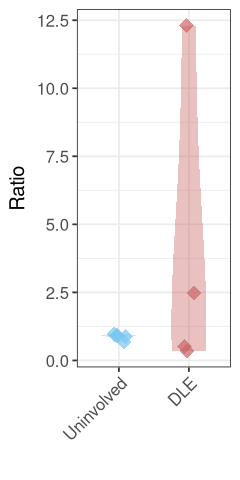

In [185]:
options(repr.plot.width=2, repr.plot.height=4)
p <- plot_tab   %>%
    mutate(DISEASE_FANCY = factor(DISEASE_NAMES[STATUS], levels=DISEASE_ORDER)) %>%
    ggplot(aes(x=DISEASE_FANCY, y=ratio)) +
    theme_bw() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(size=10, angle = 45, hjust = 1, vjust = 1), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=8), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
    xlab("") +
    ylab(expression("Ratio")) +
    scale_fill_manual(values=DISEASE_COLORS) +
    scale_color_manual(values=DISEASE_COLORS) +
    #scale_y_continuous(expand = expand_scale(mult = c(0.1, 0.5))) +
    geom_violin(aes(fill=DISEASE_FANCY), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    # geom_errorbarh(data=migrant_sum, 
    #                aes(y=MEAN, color=SUBSET, xmin=(..x..) - 0.4, xmax=(..x..) + 0.4),
    #                height=0, size=0.75, position=position_dodge(0.9), alpha=0.9) +
    geom_line(aes(group = SAMPLE), linetype = "dashed") +
    geom_jitter(aes(color=DISEASE_FANCY), size=4, pch=18, alpha=0.7, position=position_jitter(0.1)) 
plot(p)

In [503]:
# T cell frequency
plot_tab <- subset_tab %>%
    filter(cluster %in% c("0")) %>%
    group_by(SAMPLE, STATUS) %>%
    summarize(T_cell = sum(freq)) %>%
    left_join(fibroblast_df) %>% mutate(ratio = T_cell/fibroblast)
plot_tab

`summarise()` has grouped output by 'SAMPLE'. You can override using the
`.groups` argument.
Joining with `by = join_by(SAMPLE, STATUS)`


SAMPLE,STATUS,T_cell,fibroblast,ratio
<chr>,<chr>,<dbl>,<dbl>,<dbl>
CLE1,LUPUS,0.04063770,0.09127852,0.4452055
CLE2,LUPUS,0.50477445,0.14487982,3.4840909
CLE3,LUPUS,0.23319175,0.19631203,1.1878628
CLE5,LUPUS,0.28133393,0.03491495,8.0576923
CTRL1,HEALTHY,0.01946108,0.12911677,0.1507246
CTRL2,HEALTHY,0.02862986,0.06748466,0.4242424
CTRL3,HEALTHY,0.05138037,0.16411043,0.3130841
CTRL4,HEALTHY,0.02359551,0.09016854,0.2616822
CTRL5,HEALTHY,0.05416157,0.07466340,0.7254098


`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


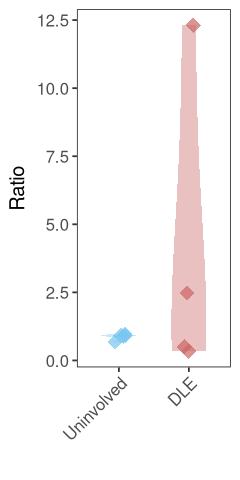

In [14]:
options(repr.plot.width=2, repr.plot.height=4)
p <- plot_tab   %>%
    mutate(DISEASE_FANCY = factor(DISEASE_NAMES[STATUS], levels=DISEASE_ORDER)) %>%
    ggplot(aes(x=DISEASE_FANCY, y=ratio)) +
    theme_bw() + 
    theme(legend.position="none", 
            panel.grid.major=element_blank(), panel.grid.minor=element_blank(),
          axis.title.x=element_text(size=12), axis.text.x=element_text(size=10, angle = 45, hjust = 1, vjust = 1), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=8), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
    xlab("") +
    ylab(expression("Ratio")) +
    scale_fill_manual(values=DISEASE_COLORS) +
    scale_color_manual(values=DISEASE_COLORS) +
    #scale_y_continuous(expand = expand_scale(mult = c(0.1, 0.5))) +
    geom_violin(aes(fill=DISEASE_FANCY), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    # geom_errorbarh(data=migrant_sum, 
    #                aes(y=MEAN, color=SUBSET, xmin=(..x..) - 0.4, xmax=(..x..) + 0.4),
    #                height=0, size=0.75, position=position_dodge(0.9), alpha=0.9) +
    geom_line(aes(group = SAMPLE), linetype = "dashed") +
    geom_jitter(aes(color=DISEASE_FANCY), size=4, pch=18, alpha=0.7, position=position_jitter(0.1)) 
plot(p)

In [506]:
plotFigure(p, file.path(plot_dir, "single_tcell_frequency.pdf"), 2, 4)

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


png 
  2

In [16]:
# pcDC cell frequency
plot_tab <- subset_tab %>%
    filter(cluster %in% c("19")) %>%
    group_by(STATUS, SAMPLE) %>%
    summarize(pcDC = sum(freq)) %>%
    left_join(fibroblast_df) %>% mutate(ratio = pcDC/fibroblast)
plot_tab

`summarise()` has grouped output by 'STATUS'. You can override using the `.groups` argument.
Joining with `by = join_by(STATUS, SAMPLE)`


STATUS,SAMPLE,pcDC,fibroblast,ratio
<chr>,<chr>,<dbl>,<dbl>,<dbl>
HEALTHY,CTRL1,0.0000000000,0.12911677,0.000000000
HEALTHY,CTRL2,0.0000000000,0.06748466,0.000000000
HEALTHY,CTRL3,0.0002556237,0.16411043,0.001557632
HEALTHY,CTRL4,0.0000000000,0.09016854,0.000000000
HEALTHY,CTRL5,0.0000000000,0.07466340,0.000000000
LUPUS,CLE1,0.0015629884,0.09127852,0.017123288
LUPUS,CLE2,0.0171221600,0.14487982,0.118181818
LUPUS,CLE3,0.0329431265,0.19631203,0.167810026
LUPUS,CLE5,0.0064905998,0.03491495,0.185897436


`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


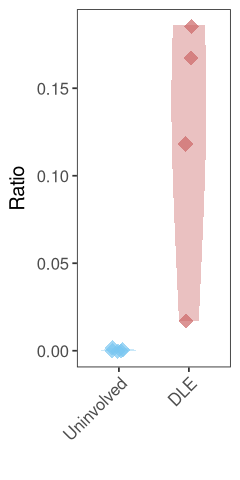

In [17]:
options(repr.plot.width=2, repr.plot.height=4)
p <- plot_tab   %>%
    mutate(DISEASE_FANCY = factor(DISEASE_NAMES[STATUS], levels=DISEASE_ORDER)) %>%
    ggplot(aes(x=DISEASE_FANCY, y=ratio)) +
    theme_bw() + 
    theme(legend.position="none", 
            panel.grid.major=element_blank(), panel.grid.minor=element_blank(),
          axis.title.x=element_text(size=12), axis.text.x=element_text(size=10, angle = 45, hjust = 1, vjust = 1), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=8), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
    xlab("") +
    ylab(expression("Ratio")) +
    scale_fill_manual(values=DISEASE_COLORS) +
    scale_color_manual(values=DISEASE_COLORS) +
    #scale_y_continuous(expand = expand_scale(mult = c(0.1, 0.5))) +
    geom_violin(aes(fill=DISEASE_FANCY), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    # geom_errorbarh(data=migrant_sum, 
    #                aes(y=MEAN, color=SUBSET, xmin=(..x..) - 0.4, xmax=(..x..) + 0.4),
    #                height=0, size=0.75, position=position_dodge(0.9), alpha=0.9) +
    geom_line(aes(group = SAMPLE), linetype = "dashed") +
    geom_jitter(aes(color=DISEASE_FANCY), size=4, pch=18, alpha=0.7, position=position_jitter(0.1)) 
plot(p)

In [18]:
plotFigure(p, file.path(plot_dir, "single_pDC_frequency.pdf"), 2, 4)

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


png 
  2

In [516]:
# B cell frequency
plot_tab <- subset_tab %>%
    filter(cluster %in% c("7")) %>%
    group_by(STATUS, SAMPLE) %>%
    summarize(B_cell = sum(freq)) %>%
    left_join(fibroblast_df) %>% mutate(ratio = B_cell/fibroblast)
plot_tab

`summarise()` has grouped output by 'STATUS'. You can override using the
`.groups` argument.
Joining with `by = join_by(STATUS, SAMPLE)`


STATUS,SAMPLE,B_cell,fibroblast,ratio
<chr>,<chr>,<dbl>,<dbl>,<dbl>
HEALTHY,CTRL1,0.007110778,0.12911677,0.05507246
HEALTHY,CTRL2,0.000000000,0.06748466,0.00000000
HEALTHY,CTRL3,0.016871166,0.16411043,0.10280374
HEALTHY,CTRL4,0.020224719,0.09016854,0.22429907
HEALTHY,CTRL5,0.011933905,0.07466340,0.15983607
LUPUS,CLE1,0.005939356,0.09127852,0.06506849
LUPUS,CLE2,0.102074416,0.14487982,0.70454545
LUPUS,CLE3,0.080907490,0.19631203,0.41213720
LUPUS,CLE5,0.054162936,0.03491495,1.55128205


`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


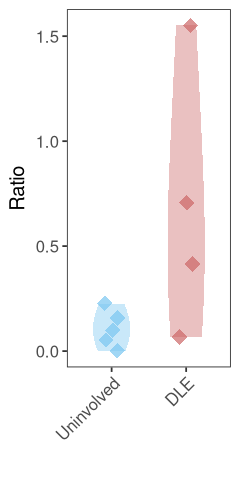

In [517]:
options(repr.plot.width=2, repr.plot.height=4)
p <- plot_tab   %>%
    mutate(DISEASE_FANCY = factor(DISEASE_NAMES[STATUS], levels=DISEASE_ORDER)) %>%
    ggplot(aes(x=DISEASE_FANCY, y=ratio)) +
    theme_bw() + 
    theme(legend.position="none", 
            panel.grid.major=element_blank(), panel.grid.minor=element_blank(),
          axis.title.x=element_text(size=12), axis.text.x=element_text(size=10, angle = 45, hjust = 1, vjust = 1), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=8), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
    xlab("") +
    ylab(expression("Ratio")) +
    scale_fill_manual(values=DISEASE_COLORS) +
    scale_color_manual(values=DISEASE_COLORS) +
    #scale_y_continuous(expand = expand_scale(mult = c(0.1, 0.5))) +
    geom_violin(aes(fill=DISEASE_FANCY), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    # geom_errorbarh(data=migrant_sum, 
    #                aes(y=MEAN, color=SUBSET, xmin=(..x..) - 0.4, xmax=(..x..) + 0.4),
    #                height=0, size=0.75, position=position_dodge(0.9), alpha=0.9) +
    geom_line(aes(group = SAMPLE), linetype = "dashed") +
    geom_jitter(aes(color=DISEASE_FANCY), size=4, pch=18, alpha=0.7, position=position_jitter(0.1)) 
plot(p)

In [518]:
plotFigure(p, file.path(plot_dir, "single_bcell_frequency.pdf"), 2, 4)

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


png 
  2

# Cell subset GEX changes

In [116]:
pseudo_immune <- AggregateExpression(immune.combined, assays = "SCT", 
                                   return.seurat = T, group.by = c("STATUS", "PATIENT", "seurat_clusters"))

In [117]:
pseudo_immune$celltype.stim <- paste(pseudo_immune$STATUS,pseudo_immune$seurat_clusters, sep = "_")

In [125]:
pseudo_immune@data

ERROR: Error in eval(expr, envir, enclos): no slot of name "data" for this object of class "Seurat"


In [126]:
Idents(pseudo_immune) <- "celltype.stim"

bulk.Tcell.de <- FindMarkers(object = pseudo_immune, 
                         ident.1 = "LUPUS_0", 
                         ident.2 = "HEALTHY_0",
                         test.use = "DESeq2", min.cells.group = 2)
head(bulk.Tcell.de , n = 15)

converting counts to integer mode

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HERC5,2.832291e-28,2.444571,1,1.0,6.237555e-24
OAS1,4.281386e-28,2.445881,1,0.8,9.428896e-24
IFIT1,3.973289e-24,3.047892,1,0.8,8.750374e-20
PLSCR1,4.561166e-23,2.750447,1,0.8,1.004506e-18
ISG20,9.718245e-22,2.367703,1,1.0,2.140249e-17
IFIT3,2.171157e-20,2.643274,1,0.8,4.781539e-16
GIMAP4,9.068934e-20,1.936717,1,0.8,1.997251e-15
UBE2L6,9.153698e-20,1.754713,1,1.0,2.015919e-15
IFIT2,5.739232e-19,2.764367,1,0.8,1.263951e-14


In [139]:
Idents(pseudo_immune) <- "celltype.stim"

bulk.endothelial.de <- FindMarkers(object = pseudo_immune, 
                         ident.1 = "LUPUS_1", 
                         ident.2 = "HEALTHY_1",
                         test.use = "DESeq2", min.cells.group = 2)
head(bulk.endothelial.de, n = 15)

converting counts to integer mode

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ALPL,2.845966e-39,2.913217,1.00,0.8,6.267672e-35
GBP5,5.137820e-22,2.784155,1.00,1.0,1.131502e-17
ACOT7,1.276012e-17,2.205053,1.00,1.0,2.810160e-13
RYR3,3.587837e-17,-1.635193,0.75,1.0,7.901493e-13
PRSS23,2.227677e-16,2.656833,1.00,1.0,4.906013e-12
DNASE1L3,5.846685e-16,2.768861,1.00,1.0,1.287616e-11
C4orf48,4.928156e-15,1.903546,1.00,1.0,1.085328e-10
TAGLN,7.136049e-15,2.288536,1.00,1.0,1.571572e-10
CFB,1.134917e-14,1.831214,1.00,1.0,2.499429e-10


In [141]:
Idents(pseudo_immune) <- "celltype.stim"

bulk.keratinocyte.de <- FindMarkers(object = pseudo_immune, 
                         ident.1 = "LUPUS_2", 
                         ident.2 = "HEALTHY_2",
                         test.use = "DESeq2", min.cells.group = 2)
head(bulk.keratinocyte.de , n = 15)

converting counts to integer mode

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OASL,1.966191e-20,2.563951,1.00,0.8,4.330142e-16
CXCL10,1.316709e-19,3.266480,1.00,0.2,2.899789e-15
IFIT2,1.473224e-19,2.965084,1.00,0.8,3.244482e-15
RSAD2,2.610058e-17,2.839317,1.00,0.8,5.748130e-13
GBP1,1.023590e-16,2.446278,1.00,1.0,2.254251e-12
KRT6C,1.812474e-15,3.673295,0.75,0.6,3.991612e-11
ISG20,1.067662e-14,2.735533,1.00,1.0,2.351313e-10
KLHDC7B,2.466665e-13,2.001779,1.00,0.0,5.432337e-09
MX2,2.472559e-13,2.608081,1.00,0.8,5.445317e-09


In [144]:
Idents(pseudo_immune) <- "celltype.stim"

bulk.fibroblast.de <- FindMarkers(object = pseudo_immune, 
                         ident.1 = "LUPUS_4", 
                         ident.2 = "HEALTHY_4",
                         test.use = "DESeq2", min.cells.group = 2)
head(bulk.fibroblast.de  , n = 15)

converting counts to integer mode

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IFIT2,3.434797e-29,4.301563,1,0.8,7.564454e-25
PSMB9,1.581146e-28,2.709996,1,1.0,3.482158e-24
WARS,7.087912e-26,2.894126,1,1.0,1.560971e-21
CD68,3.164639e-23,3.411698,1,0.8,6.969484e-19
LAP3,6.083451e-23,2.512318,1,1.0,1.339759e-18
TNFSF13B,8.408926e-21,2.984313,1,0.8,1.851898e-16
TNFSF10,1.971100e-20,3.050942,1,1.0,4.340953e-16
HLA-B,3.013227e-20,2.232240,1,1.0,6.636031e-16
UBE2L6,5.029200e-20,2.453278,1,1.0,1.107581e-15


# Identify cluster assignments (SCRATCH)

In [164]:
immune.combined <- PrepSCTFindMarkers(immune.combined)

Found 9 SCT models. Recorrecting SCT counts using minimum median counts: 970



In [163]:
select_markers <- FindMarkers(immune.combined, ident.1 = 16)

Warning message in mean.fxn(object[features, cells.1, drop = FALSE]):
“NaNs produced”


In [165]:
select_markers %>% head(30) %>% rownames() %>% unlist()

[1] "RPLP1"    "FAM43A"   "TSPAN8"   "DPYSL3"   "CD74"     "GIMAP5"  
 [7] "AP1S2"    "IL32"     "CD14"     "ITGBL1"   "ADGRF5"   "TFPI2"   
[13] "C4orf48"  "ICAM2"    "CXCL2"    "ENPP2"    "NFATC2"   "C1QTNF1" 
[19] "TSPAN2"   "SLC9A3R2" "RGS5"     "GPSM3"    "CD248"    "IRF8"    
[25] "PPP1R3C"  "IRF4"     "MXRA8"    "ST8SIA4"  "HEY1"     "PLCB4"

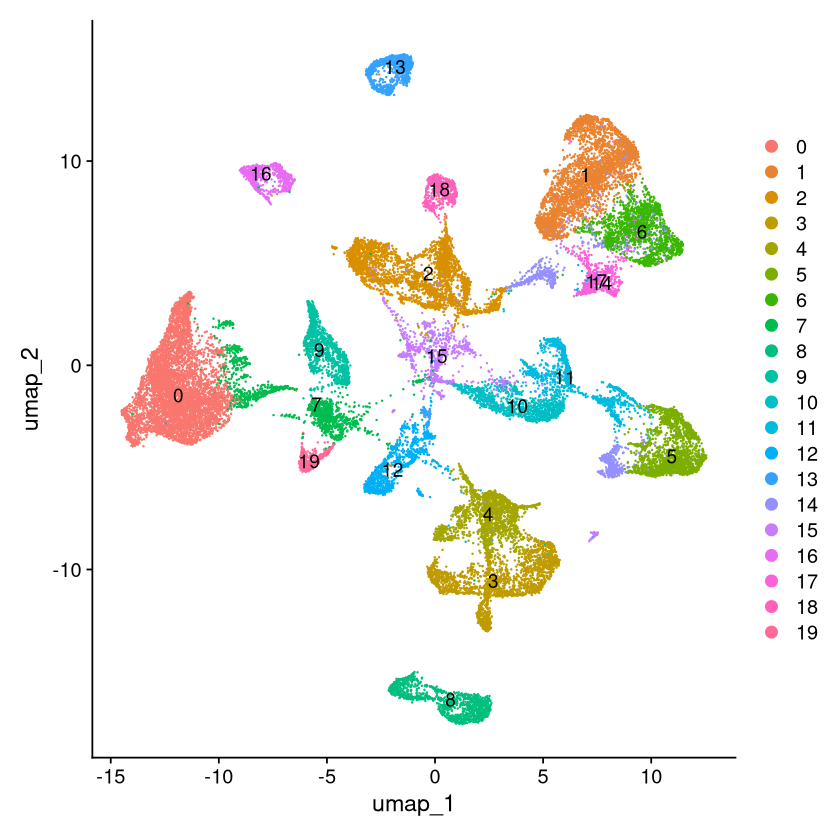

In [93]:
DimPlot(immune.combined,label = TRUE)

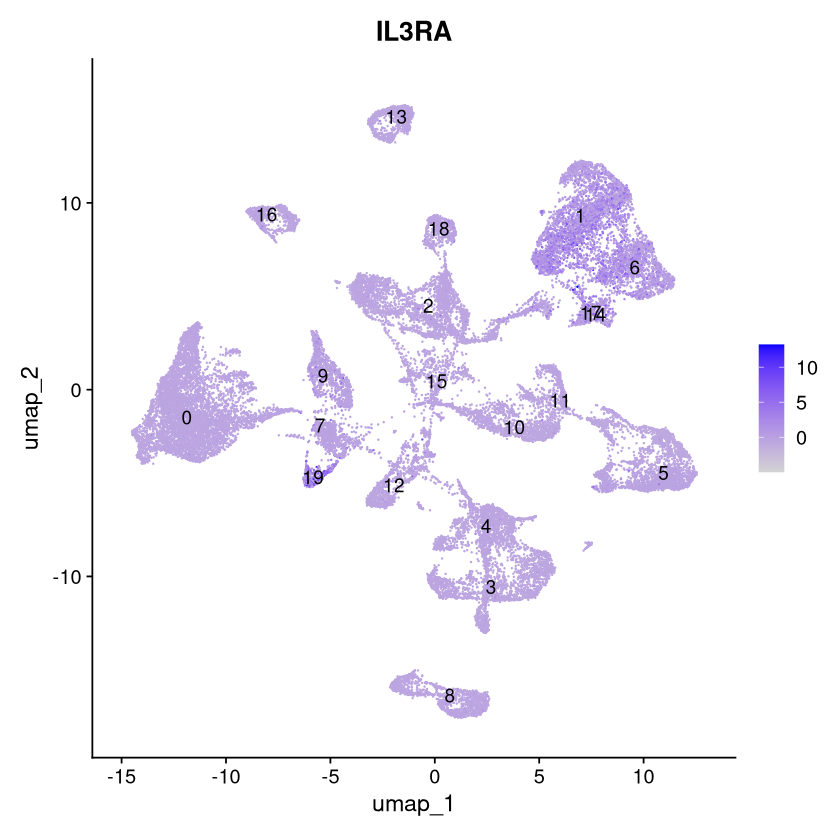

In [70]:
FeaturePlot(immune.combined, feature = "IL3RA", label = TRUE)

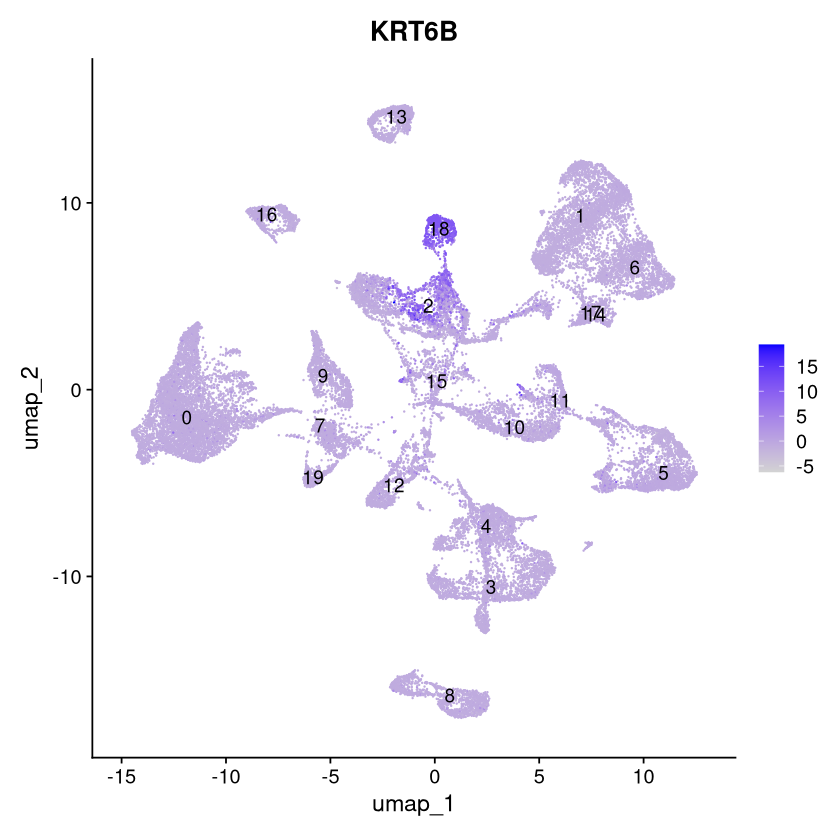

In [35]:
FeaturePlot(immune.combined, feature = "KRT6B", label = TRUE)

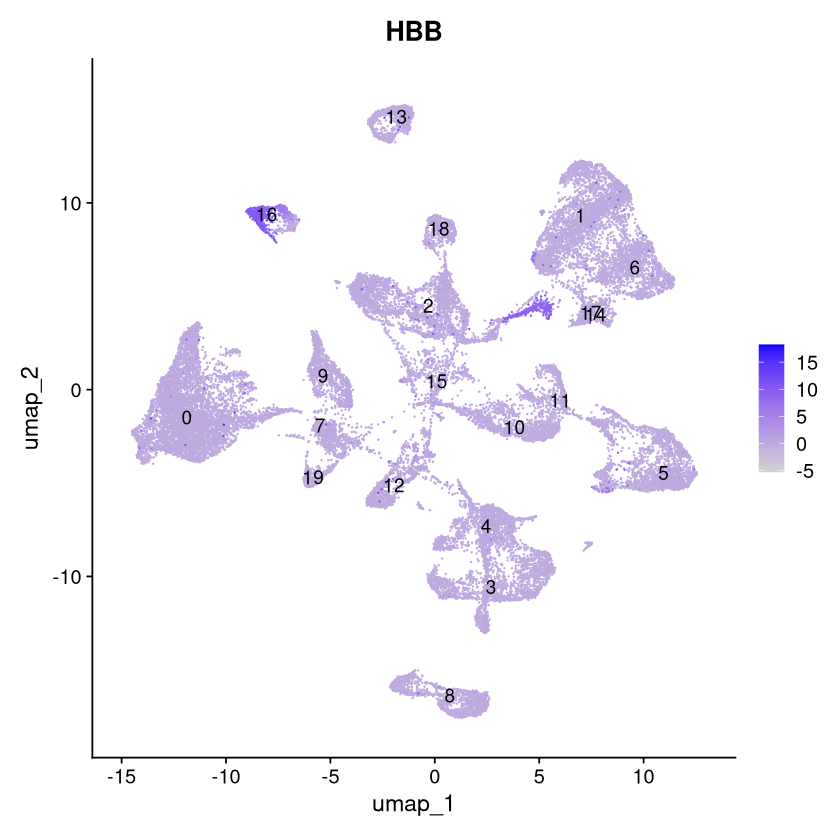

In [109]:
FeaturePlot(immune.combined, feature = "HBB", label = TRUE)

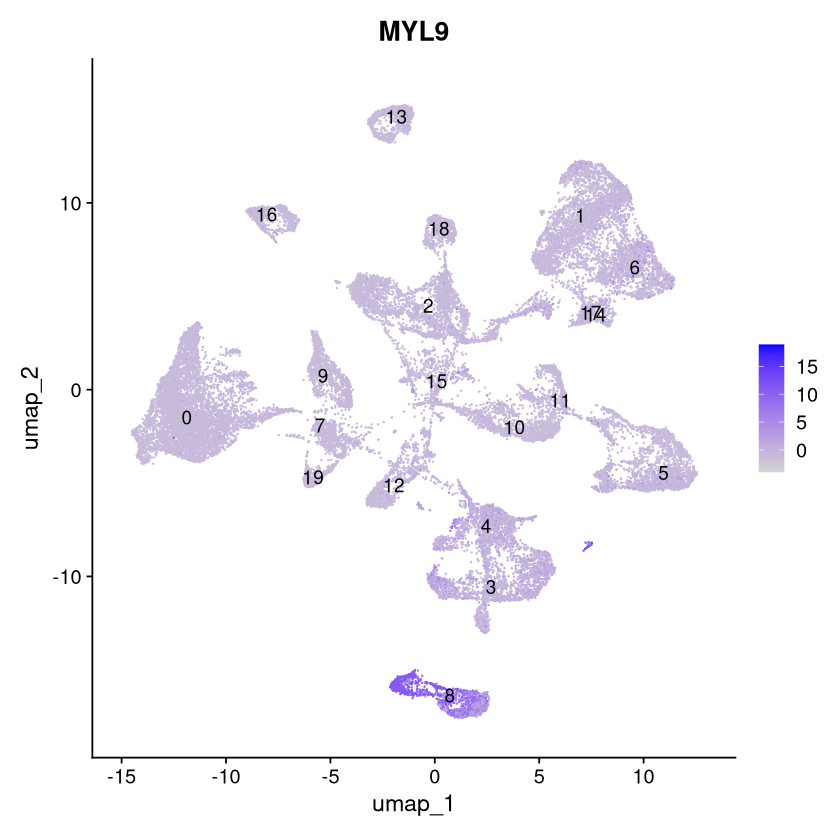

In [143]:
FeaturePlot(immune.combined, feature = "MYL9", label = TRUE)

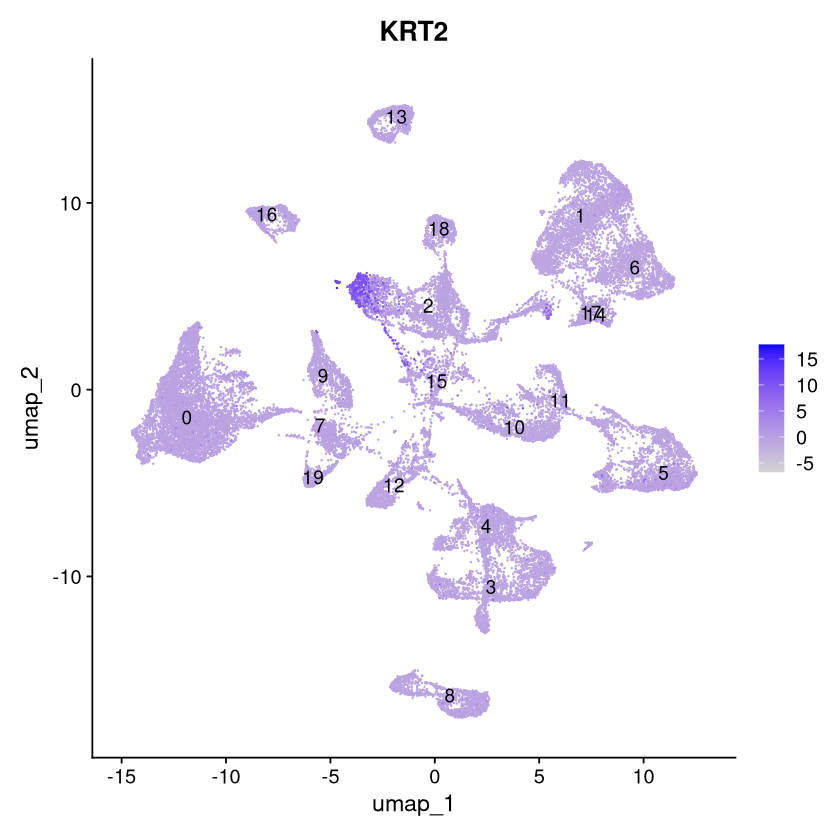

In [131]:
FeaturePlot(immune.combined, feature = "KRT2", label = TRUE)

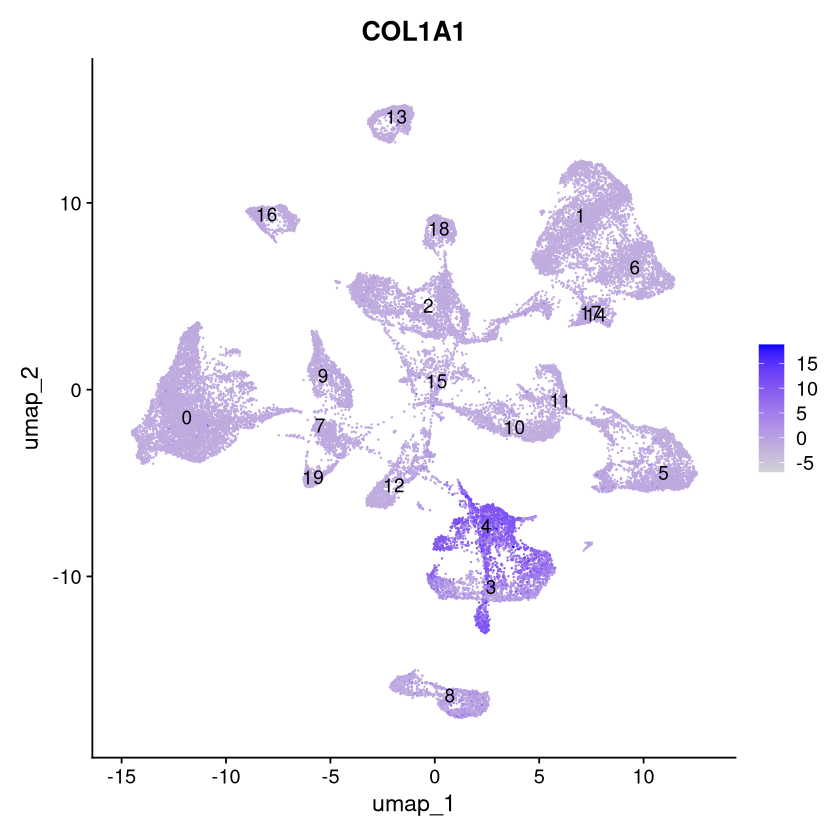

In [130]:
FeaturePlot(immune.combined, feature = "COL1A1", label = TRUE)

# Save object

In [113]:
saveRDS(immune.combined, file.path(output_dir, "single.combined.rds"))

In [6]:
immune.combined <- readRDS(file.path(output_dir, "single.combined.rds"))

In [25]:
singlecell_assignment <- read.csv("/home/ruoyi/Dropbox/Projects/Gelhausen_CLE/Spatial/singlecell_assignment.csv")

In [53]:
rename_vector <- singlecell_assignment$assignment
names(rename_vector) <- singlecell_assignment$seurat_clusters

In [54]:
immune.combined <- RenameIdents(immune.combined, rename_vector)

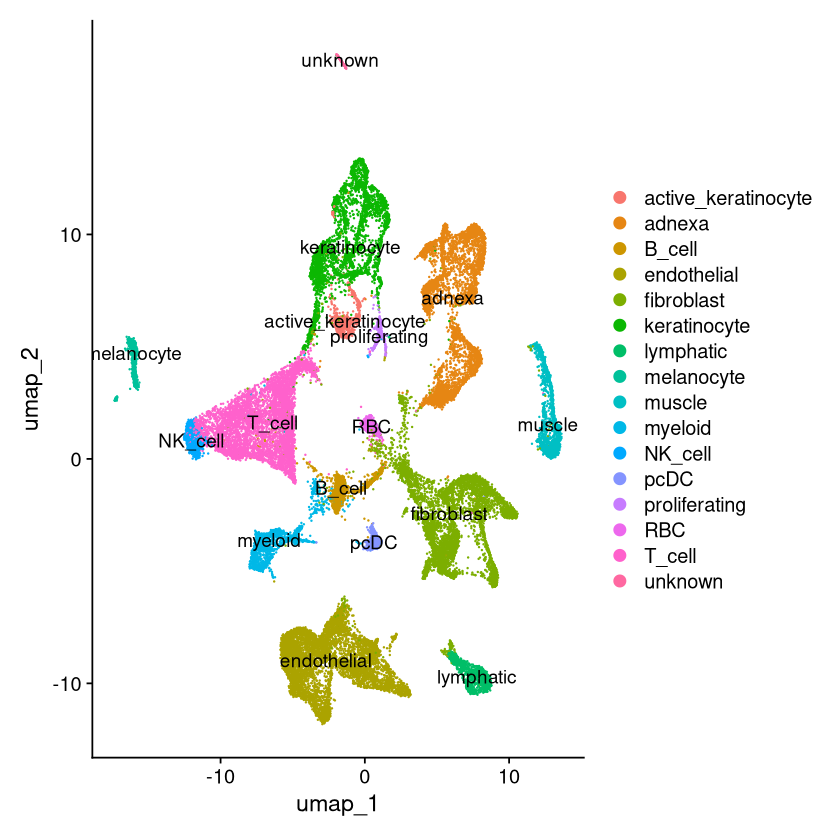

In [55]:
DimPlot(immune.combined, reduction = "umap", label = TRUE)

In [58]:
saveRDS(immune.combined, file.path(output_dir, "single.combined.rds"))